In [1]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Reshape, Flatten, Dropout, BatchNormalization
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import copy
from tensorflow.keras import backend as K
from sklearn import preprocessing
import tensorflow.keras.optimizers as optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

## Separate splits

In [2]:
def augument_sample(sample, averages, stds):
    return None
    
    
def format_data(df, lookback_window=12):
    x = []
    y = []
    for i in range(len(df)-lookback_window):
        x_entry = copy(df[i:i+lookback_window].values.T) # include current value
        x_entry[0][lookback_window-1] = 0.0 # erase variable to be predicted
        x.append(x_entry)
        y_entry = df['total_cases'][i+lookback_window-1]
        y.append(y_entry)
        
    x = np.array(x)
    y = np.array(y)
    return x, y

In [3]:
def split(x, y, val_size):
    train_size = len(x)-val_size
    x_train, y_train = x[0:train_size], y[0:train_size]
    x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size]
    
    assert y_train.shape[0]+y_val.shape[0] == len(y)
    
    return x_train, y_train, x_val, y_val

## Model with Autoregressive MLP

In [4]:
def get_model(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m =  Flatten()(m)
    m = Dense(500, activation='relu')(m)
    m = BatchNormalization()(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)

    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

In [5]:
def train_model(model, data, epochs=200, plot=True):
    start_time = time.time()
    print('Training...')
    x_train, y_train, x_val, y_val = data
    validation_data = (x_val, y_val)
    history = model.fit(x_train, y_train, epochs=epochs,
                        verbose=False, validation_data=validation_data, batch_size=50)
    elapsed_time = time.time() - start_time
    
    print("Elapsed Time: {}".format(elapsed_time))
    
    if plot:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.ylim(0, 40)
        plt.legend(loc='upper right')
        plt.show()
    


In [6]:
def plot_train_val(model, data):
    x_train, y_train, x_val, y_val = data
    p = model.predict(x_train)
    plt.plot(y_train, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

    p = model.predict(x_val)
    plt.plot(y_val, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()
    


## Forecasting

In [16]:
def forecast(model, forecast_window, last_train, test_data):
    lookback_window = last_train.shape[1]
    current = np.expand_dims(last_train, axis=0)
    next_y = model.predict(current)[0][0]
    current[0][0][-1] = next_y
    
    result = []
    for xi in test_data:
        xi[0][0:lookback_window] = current[0][0][-lookback_window:]
        current = np.expand_dims(xi, axis=0)
        next_y = model.predict(current)[0][0]
        current[0][0][-1] = next_y
        result.append(next_y)
    
    return result
    
def fake_test_data(x_val):
    x_test = copy(x_val)
    for i in x_test:
        i[0] = 0.0
    return x_test

def forecast_analysis(model, data):
    x_train, y_train, x_val, y_val = data
    x_test = fake_test_data(x_val)
    result = forecast(model, len(x_test), copy(x_train[-1]), x_test)
    error = mean_absolute_error(y_val, result)
    print("Forecast MAE: {}".format(error))

    plt.plot(y_val, label='actual')
    plt.plot(result, label='forecast')
    plt.title('Weekly Dengue Cases Forecasting')
    plt.legend()
    plt.show()
    return result

## Load Data
- Load data from csv
- Merge dataframes
- Choose city
- Remove string columns

In [8]:
def load_data(lookback_window, city):
    labels = pd.read_csv('../data/dengue_labels_train.csv', parse_dates=True)
    features = pd.read_csv('../data/dengue_features_train.csv', parse_dates=True)

    all_data = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])
    city_data = all_data[all_data.city == city]
    df = city_data.drop(['city', 'week_start_date'], axis=1)
    df = df.reset_index()
    df = df.drop(['index'], axis=1).sort_values(['year', 'weekofyear'], ascending=[True, True])

    # Move "total_cases" to column 0 to avoid bugs
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('total_cases')))
    df = df.loc[:, cols]

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [9]:
# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler.fit(x)
# x_scaled = min_max_scaler.transform(x)
# df = pd.DataFrame(x_scaled, columns=df.columns)

## Model / Train / Forecast

In [10]:
K.clear_session()

## San Juan

In [11]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')


x, y = format_data(df_sj, lookback_window_sj)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 23, 170)
(766,)
(498, 23, 170)
(498,)
(268, 23, 170)
(268,)


W0929 23:07:33.915202 139997093721920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(?, 23, 170)
Training...
Elapsed Time: 92.65931463241577


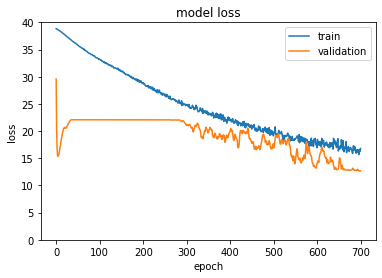

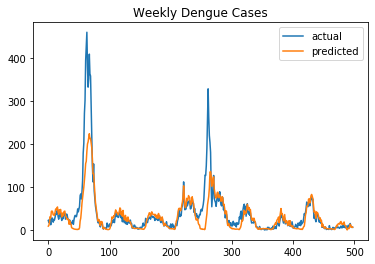

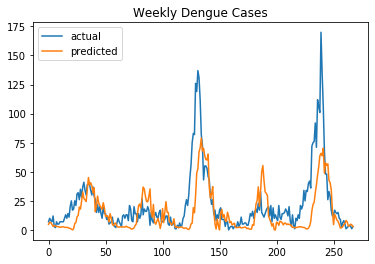

Forecast MAE: 15.10799612571944


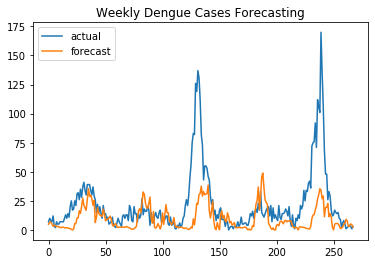

In [12]:
input_shape = (x.shape[1], x.shape[2])
model_sj = get_model(input_shape)
train_model(model_sj, data, epochs=700)
plot_train_val(model_sj, data)
forecast_analysis(model_sj, data)

## Iquitos

In [13]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')
x, y = format_data(df_iq, lookback_window_iq)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 23, 150)
(370,)
(241, 23, 150)
(241,)
(129, 23, 150)
(129,)


(?, 23, 150)
Training...
Elapsed Time: 37.735639572143555


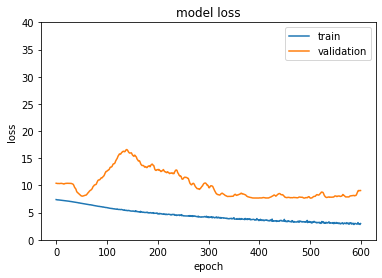

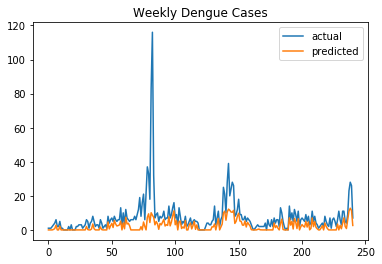

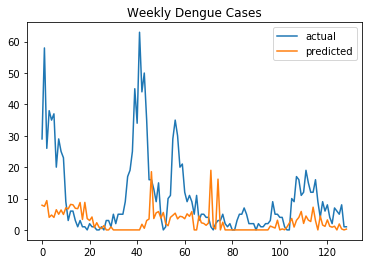

Forecast MAE: 9.289809425845165


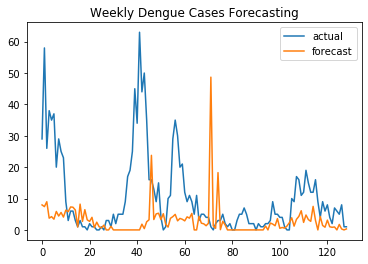

In [14]:
input_shape = (x.shape[1], x.shape[2])
model_iq = get_model(input_shape)
train_model(model_iq, data, epochs=600)
plot_train_val(model_iq, data)
forecast_analysis(model_iq, data)

# Submission Code #TODO

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(1026, 23, 170)
(1026,)


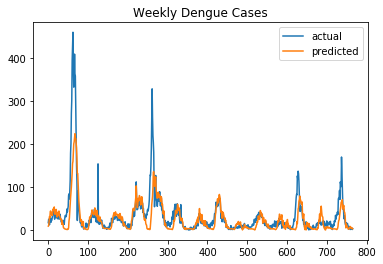

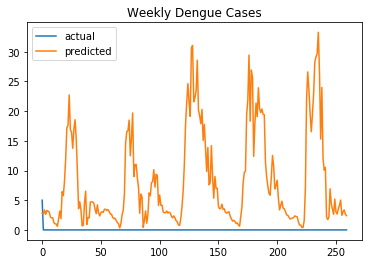

Forecast MAE: 6.677536366249506


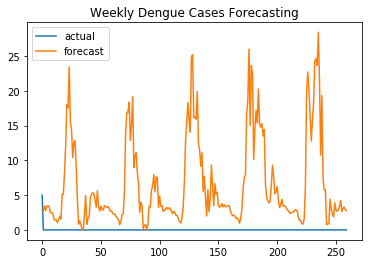

260
260


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(526, 23, 150)
(526,)


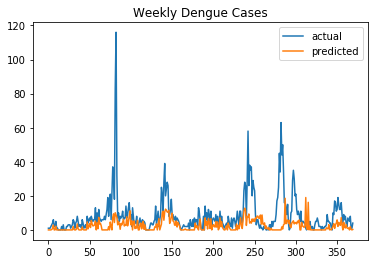

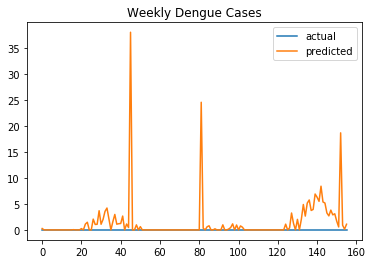

Forecast MAE: 1.6927928713938365


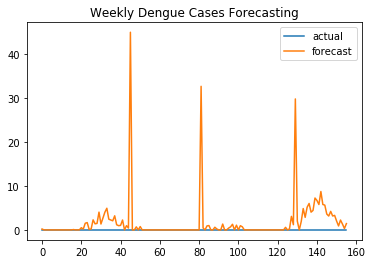

156
156


In [32]:
def forecast_on_test_data(model, df_train_val, city, lookback_window):
    labels = pd.read_csv('../data/submission_format.csv', parse_dates=True)
    features = pd.read_csv('../data/dengue_features_test.csv', parse_dates=True)

    df_test = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])

    df_test = df_test[df_test.city == city]
    df_test = df_test.drop(['city', 'week_start_date'], axis=1)
    len_test = len(df_test)
    
    df_full = pd.concat([df_train_val, df_test])
    df_full = df_full.reset_index()
    df_full = df_full.drop(['index'], axis=1).sort_values(['year', 'weekofyear'], ascending=[True, True])
    df_full.fillna(method='ffill', inplace=True)
    df_full.fillna(method='bfill', inplace=True)

    # Ensure the same order of columns
    cols = list(df_train_val)
    cols.insert(0, cols.pop(cols.index('total_cases')))
    df_full = df_full.loc[:, cols]

    x, y = format_data(df_full, lookback_window)
    print(x.shape)
    print(y.shape)
    x_train, y_train, x_test, y_test = split(x, y, len_test)
    data = x_train, y_train, x_test, y_test
    plot_train_val(model, data)
    results = forecast_analysis(model, data)
    
    df_results = labels[labels.city == city].reset_index()
    print(len(df_results))
    print(len(results))
    df_results['total_cases'] = np.array(results).astype(int)
    return df_results.drop(['index'], axis=1)
    


df_results_sj = forecast_on_test_data(model_sj, df_sj, city='sj', lookback_window=lookback_window_sj)
df_results_iq = forecast_on_test_data(model_iq, df_iq, city='iq', lookback_window=lookback_window_iq)

In [38]:
submission_dataframe = pd.concat([df_results_sj, df_results_iq])
submission_dataframe = submission_dataframe.sort_values(['city','year', 'weekofyear'],
                                                        ascending=[False, True, True])
submission_dataframe.to_csv("submission.csv", index=False)